# Model

## Description
Here I will create a model, which is able to read a video input stream and uses a single frame as input information for the model.
The goal is to train the model with image from hands playing *Rock Paper Scissors* to later use it as opponent in an proof-of-concept program.

### Neural networks

Neural networks have an input layer, hidden layers and an output layer. Usually, there are as many input neurons are there is information (e.g. pixels) in the given data.
The hidden layers is a layered representation of data; both loosely and densly coupled networks exist. Most of the time for each class predictable, one output neuron exits. All values usually sum up to one and can thus be represented as a probability distribution.

### Weights
Each connection between neurons have a certain weight. It is these weights that are being adjusted by backpropagation.

### Biases
Biases are constant values, which provide a separate influence value for each hidden layer.

### Activation functions


$Y =F((\sum_{i=0}^n w_i x_i) + b)$ is used for the final output of the neuron, also considering its activation function.
Activation functions constraint and influence the weights of neurons.

### Gradient Descent

A gradient descend functions calulates the best values, which are backpropagated to the individuals neurons to improve the weights.
The terminal goal is to reach the global minimum, below shown in dark blue.

<img src="gradient_descent.jpg">

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import platform

In [20]:
#Load in dataset from TensorFlow
tfds.list_builders()
(datasetTrain, datasetTest), datasetInfo = tfds.load(name='rock_paper_scissors',data_dir='rockpaperscissorData', with_info=True,as_supervised=True, split=[tfds.Split.TRAIN, tfds.Split.TEST])

In [21]:
#print(datasetTrain)
datasetInfo

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_path='rockpaperscissorData\\rock_paper_scissors\\3.0.0',
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
)

In [4]:
labelNames = datasetInfo.features['label'].int2str

In [22]:
#Print all label, which are rock, paper, scissors here
print(labelNames(0), labelNames(1), labelNames(2))

#Cache size and shape of imported image data
INPUT_IMAGE_SIZE = datasetInfo.features['image'].shape[0]
INPUT_IMAGE_SHAPE = datasetInfo.features['image'].shape

print("Image size is: " , INPUT_IMAGE_SIZE)
print("Image shape is: " , INPUT_IMAGE_SHAPE)

rock paper scissors
Image size is:  300
Image shape is:  (300, 300, 3)


In [6]:
NUMBER_TRAIN_EXAMPLES = datasetInfo.splits['train'].num_examples
NUMBER_TEST_EXAMPLES = datasetInfo.splits['test'].num_examples
NUMBER_CLASSES = datasetInfo.features['label'].num_classes

print("Number of examples for training: ", NUMBER_TRAIN_EXAMPLES)
print("Number of examples for testing: ", NUMBER_TEST_EXAMPLES)

#This should be three.
print("Number of classes: ", NUMBER_CLASSES)

Number of examples for training:  2520
Number of examples for testing:  372
Number of classes:  3


In [49]:
IMG_SIZE = 300
def FormatImages(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image, label

In [50]:
datasetTrainFormatted = datasetTrain.map(FormatImages)
datasetTestFormatted = datasetTest.map(FormatImages)

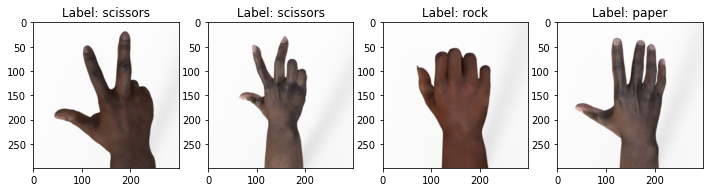

In [51]:
plt.figure(figsize=(12,12))
index = 0
for features in datasetTrainFormatted.take(4):
    (image, label) = features
    index += 1
    label = labelNames(label.numpy())
    plt.subplot(1,4, index)
    plt.title('Label: %s' % label)
    plt.imshow(image.numpy())

### Shuffling and Batching

In [52]:
BATCH_SIZE = 32

#Train data set
datasetTrainShuffled = datasetTrainFormatted.shuffle(buffer_size=NUMBER_TRAIN_EXAMPLES)
datasetTrainShuffled = datasetTrainShuffled.batch(batch_size=BATCH_SIZE)

#Prefetch allows the input pipeline to asynchronously fetch batches
datasetTrainShuffled = datasetTrainShuffled.prefetch( buffer_size=tf.data.experimental.AUTOTUNE)

#Test data set
dataSetTestShuffled = datasetTestFormatted.batch(BATCH_SIZE)

#print(datasetTrainFormatted)

In [59]:
model = tf.keras.models.Sequential()

#Setup convolution neural network
#First layer
model.add(tf.keras.layers.Convolution2D(input_shape=INPUT_IMAGE_SHAPE, filters=64, kernel_size=3, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))

#Second layer
model.add(tf.keras.layers.Convolution2D(filters=64, kernel_size=3, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#Third layer
model.add(tf.keras.layers.Convolution2D(filters=128, kernel_size=3, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#Fourth layer
model.add(tf.keras.layers.Convolution2D(filters=128, kernel_size=3, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#Here I create the dense neural network
#First flatten the input
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
 
model.add(tf.keras.layers.Dense(units=512, activation=tf.keras.activations.relu))

#This is the output layer. It has as much units as there are classes, which is in this case 3.
model.add(tf.keras.layers.Dense(units=NUMBER_CLASSES,activation=tf.keras.activations.softmax))

In [60]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 298, 298, 64)      1792      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 147, 147, 64)      36928     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 33, 33, 128)      

In [61]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [62]:
BASE_LEARNING_RATE = 0.0001
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=BASE_LEARNING_RATE)
model.compile(
    optimizer=rmsprop_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'])

In [63]:
#Note '//' is floor division!
stepsPerEpoch = NUMBER_TRAIN_EXAMPLES // BATCH_SIZE
validationSteps = NUMBER_TEST_EXAMPLES // BATCH_SIZE

training_history = model.fit(
    x=datasetTrainShuffled.repeat(),
    validation_data=dataSetTestShuffled.repeat(),
    epochs=2,
    steps_per_epoch=stepsPerEpoch,
    validation_steps=validationSteps,
    verbose=1
)

Epoch 1/2
78/78 [==============================] - 189s 2s/step - loss: 0.6734 - accuracy: 0.7244 - val_loss: 0.7190 - val_accuracy: 0.5909
Epoch 2/2
78/78 [==============================] - 186s 2s/step - loss: 0.1068 - accuracy: 0.9695 - val_loss: 0.3602 - val_accuracy: 0.8551


### Evaluate

In [64]:
train_loss, train_accuracy = model.evaluate(
    x=datasetTestFormatted.batch(BATCH_SIZE).take(NUMBER_TEST_EXAMPLES))

12/12 [==============================] - 6s 450ms/step - loss: 0.3675 - accuracy: 0.8495


### Save and export model

In [19]:
model.save("RPS_CNN.h5", save_format="h5")